<a href="https://colab.research.google.com/github/manginoja/455/blob/main/ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
from torchvision import *
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

!pip install --upgrade --force-reinstall --no-deps kaggle

from google.colab import files
files.upload()
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c birds-22wi

!unzip birds-22wi.zip

cuda:0
     |████████████████████████████████| 58 kB 3.0 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73051 sha256=78d0aaf7cbe3788f674c8ca6d3b1f67a897849a83ddc6946150ccf1453d2c23a
  Stored in directory: /root/.cache/pip/wheels/62/d6/58/5853130f941e75b2177d281eb7e44b4a98ed46dd155f556dc5
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


Streaming output truncated to the last 5000 lines.
  inflating: birds/train/535/178aee8e17ce4c5d91704f25e0bfbb3b.jpg  
  inflating: birds/train/535/24d7923305134b49a3ef6f86186620d0.jpg  
  inflating: birds/train/535/521c8eeca4104aa08a73bc3f5baf6837.jpg  
  inflating: birds/train/535/5aa7cea9fc2648b5a0321c80fbbbc7ed.jpg  
  inflating: birds/train/535/5b696e2e34724cd79f09594af2f25d54.jpg  
  inflating: birds/train/535/5bb145ba9e7149f5b51a9b2a49731ce4.jpg  
  inflating: birds/train/535/6316fab78cc3446eb41a375aa7103b02.jpg  
  inflating: birds/train/535/66eb23f1980147fb95b0efca733c3e76.jpg  
  inflating: birds/train/535/767c16bbcbaf423cba30f2c6e910785f.jpg  
  inflating: birds/train/535/833d1dd47df946d796fb05de700527df.jpg  
  inflating: birds/train/535/8c1e2eca0f7243ffa7357bfb9a609d60.jpg  
  inflating: birds/train/535/91caf8a46020402383b9caaafbc2852e.jpg  
  inflating: birds/train/535/96d2a466540445c6b915862079aef6c1.jpg  
  inflating: birds/train/535/9bde67300b9e425784fe2508a183d502.jpg

In [4]:
def get_bird_data(augmentation=0):
  # Data augmentation transformations. Not for Testing!
  resize = 224 # probably a good size because resnet is trained on 224 x 224 images
  if augmentation:
    transform_train = transforms.Compose([
      transforms.Resize((resize, resize)),
      transforms.RandomCrop(112, padding=4, padding_mode='edge'), # Take 32x32 crops from 40x40 padded images
      transforms.RandomHorizontalFlip(),    # 50% of time flip image along y-axis 2 -> 5
      transforms.ToTensor(),
      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])
  else: 
    transform_train = transforms.Compose([
      transforms.Resize((resize, resize)),
      transforms.ToTensor(),
      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

  transform_test = transforms.Compose([transforms.Resize((resize, resize)),transforms.ToTensor()])

  full_set = torchvision.datasets.ImageFolder(root='./birds/train', transform=transform_train)
  

  train_size = int(0.8 * len(full_set))
  test_size = int((len(full_set) - train_size) / 2)
  valid_size = test_size + 1
  train_set, test_set, valid_set = torch.utils.data.random_split(full_set, [train_size, test_size, valid_size])

  trainloader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True, num_workers=2)
  testloader = torch.utils.data.DataLoader(test_set, batch_size=128, shuffle=False, num_workers=2)
  validloader = torch.utils.data.DataLoader(valid_set, batch_size=128, shuffle=False, num_workers=2)
  
  csv = pd.read_csv('./birds/labels.csv')
  classes = csv['class'].unique()
  return {'train': trainloader, 'valid': validloader, 'test': testloader, 'classes': classes}, train_set, valid_set;

data, train_set, valid_set = get_bird_data(augmentation=1)

In [5]:
net = models.resnet50(pretrained=True)
net = net.cuda() if device else net

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [6]:
use_cuda = True
num_ftrs = net.fc.in_features
net.fc = nn.Linear(num_ftrs, 555)
net.fc = net.fc.cuda() if use_cuda else net.fc

In [7]:
def train(net, dataloader, validloader, epochs=1, lr=0.01, momentum=0.9, decay=0, verbose=1):
  net.to(device)
  losses = []
  valid_losses = []
  
  criterion = nn.CrossEntropyLoss() # Combination softmax + negative log likelihood
  optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum, weight_decay=decay)
  for epoch in range(epochs):
    sum_loss = 0.0
    for i, batch in enumerate(dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = batch[0].to(device), batch[1].to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize 
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()  # autograd magic, computes all the partial derivatives
        optimizer.step() # takes a step in gradient direction

        # print statistics
        losses.append(loss.item())
        sum_loss += loss.item()
        #if i % 100 == 99:    # print every 100 mini-batches
        if verbose:
          print('[%d, %5d] loss: %.3f' %
              (epoch + 1, i + 1, sum_loss / 100))
        sum_loss = 0.0
    for i, batch in enumerate(validloader, 0):
      with torch.no_grad():
      # get the inputs; data is a list of [inputs, labels]
        inputs, labels = batch[0].to(device), batch[1].to(device)
        # zero the parameter gradients
        #optimizer.zero_grad()

        # forward + backward + optimize 
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        #loss.backward()  # autograd magic, computes all the partial derivatives
        #optimizer.step() # takes a step in gradient direction

        # print statistics
        valid_losses.append(loss.item())
        sum_loss += loss.item()
        #if i % 100 == 99:    # print every 100 mini-batches
        if verbose:
          print('[%d, %5d] loss: %.3f' %
              (epoch + 1, i + 1, sum_loss / 100))
        sum_loss = 0.0
  return losses, valid_losses

def accuracy(net, dataloader):
  correct = 0
  total = 0
  with torch.no_grad():
      for batch in dataloader:
          images, labels = batch[0].to(device), batch[1].to(device)
          outputs = net(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
  return correct/total

def smooth(x, size):
  return np.convolve(x, np.ones(size)/size, mode='valid')

In [15]:
net.load_state_dict(torch.load("birds3.pth"))

<All keys matched successfully>

In [ ]:
#torch.save(net.state_dict(), "birds.pth")
losses, valid_losses = train(net, data['train'], data['valid'], epochs=5, lr=.00002, decay = 0.0005)

[1,     1] loss: 0.025
[1,     2] loss: 0.025
[1,     3] loss: 0.024
[1,     4] loss: 0.028
[1,     5] loss: 0.027
[1,     6] loss: 0.028
[1,     7] loss: 0.026
[1,     8] loss: 0.026
[1,     9] loss: 0.026
[1,    10] loss: 0.023
[1,    11] loss: 0.025
[1,    12] loss: 0.026
[1,    13] loss: 0.027
[1,    14] loss: 0.026
[1,    15] loss: 0.027
[1,    16] loss: 0.026
[1,    17] loss: 0.024
[1,    18] loss: 0.024
[1,    19] loss: 0.024
[1,    20] loss: 0.027
[1,    21] loss: 0.027
[1,    22] loss: 0.023
[1,    23] loss: 0.026
[1,    24] loss: 0.024
[1,    25] loss: 0.026
[1,    26] loss: 0.026
[1,    27] loss: 0.024
[1,    28] loss: 0.023
[1,    29] loss: 0.026
[1,    30] loss: 0.025
[1,    31] loss: 0.025
[1,    32] loss: 0.027
[1,    33] loss: 0.024
[1,    34] loss: 0.026
[1,    35] loss: 0.024
[1,    36] loss: 0.025
[1,    37] loss: 0.025
[1,    38] loss: 0.023
[1,    39] loss: 0.029
[1,    40] loss: 0.028
[1,    41] loss: 0.027
[1,    42] loss: 0.026
[1,    43] loss: 0.025
[1,    44] 

Training accuracy: 0.856657
Testing  accuracy: 0.598548


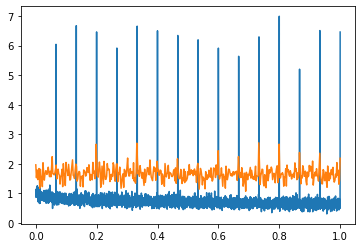

In [ ]:
x1 = np.linspace(0, 1, 242 * 15)
x2 = np.linspace(0, 1, 31 * 15)
plt.plot(x1, losses)
plt.plot(x2, valid_losses)

print("Training accuracy: %f" % accuracy(net, data['train']))
print("Testing  accuracy: %f" % accuracy(net, data['test']))

https://stackoverflow.com/questions/31003155/plotting-two-different-arrays-of-different-lengths

In [ ]:
!touch bird_model.p

In [8]:
!pip install -U fastai

     |████████████████████████████████| 189 kB 4.2 MB/s 
     |████████████████████████████████| 55 kB 5.8 MB/s 
  Attempting uninstall: fastai
    Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61


In [11]:
from fastai.vision.all import *
from fastai.data.core import DataLoaders

SuggestedLRs(valley=1.737800812406931e-05)

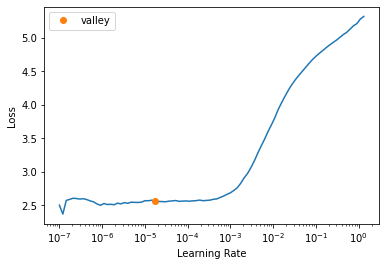

In [16]:
dls = DataLoaders.from_dsets(train_set, valid_set)
learn = Learner(dls, net, loss_func=nn.CrossEntropyLoss(), wd=0.0005)
learn.lr_find()

Tried so far:

3 epochs, lr 0.03, decay .00075, 

end loss: 0.028 (really 0.071), train acc: 0.42, test acc: 0.38

Notes: kinda hovered around .028 (0.024 -> .032)

3 epochs, lr 0.05, decay 0.0005, 

end loss: .027, train acc: .412, test acc 0.357

Notes: Same thing

3 epochs, lr 0.05, decay 0.00025

end loss: .024, train acc: 0.457, test acc: 0.395

Notes: Same thing, a little lower (0.24)

3 epochs, lr 0.05, decay 0

end loss: .021, train acc: 0.52, test acc: 0.438

Notes: Same thing, a little lower (0.21)

3 epochs, lr 0.05, decay 0

end loss: .014, train acc: 0.626, test acc: 0.52

Notes: Same thing, a little lower (0.21)

3 epochs, lr 0.02, decay 0

end loss: .014, train acc: 0.68, test acc: 0.54


0.07 for 5, 0.08 for 5, 0.1 for 1, 0.08 for 10, 0.02 for 20, 0.005 for 5, .01 for 10

0.1 for 5 (0.06), 0.05 for 10, 0.03


60 epochs at lr = .001, decay 0.0005
30 at lr = .001, decay = 0